In [1]:
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
# https://jaketae.github.io/study/pytorch-rnn/

In [2]:
import os
import random
from string import ascii_letters

import torch
from torch import nn
import torch.nn.functional as F
from unidecode import unidecode
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

from dataset import get_tensor, get_train_test_data
from model import GRUModel
from train import train, evaluate, train_rnn, evaluate_rnn
from config import *

_ = torch.manual_seed(42)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(device)

cpu


In [3]:
data_dir = "../data/names"
tensor_names, target_langs, num_langs, num_letters = get_tensor(data_dir)
train_dataset, test_dataset = get_train_test_data(tensor_names, target_langs)

num_lang, 18 num_letters 59
Train: 18063
Test: 2007


In [4]:
names, labels = next(iter(train_dataset))
print(names.shape)

torch.Size([10, 1, 59])


In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_size2 = hidden_size//2
        #self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.hidden2hidden2 = nn.Linear(input_size + self.hidden_size2, self.hidden_size2)
        self.hidden2output = nn.Linear(hidden_size+self.hidden_size2, output_size)
        
        torch.nn.init.normal(self.hidden2hidden1.weight, mean=0., std=0.05)
        torch.nn.init.normal(self.hidden2hidden2.weight, mean=0., std=0.05)
        torch.nn.init.normal(self.hidden2output.weight, mean=0., std=0.05)
        
        torch.nn.init.zeros_(self.hidden2hidden1.bias)
        torch.nn.init.zeros_(self.hidden2hidden2.bias)
        torch.nn.init.zeros_(self.hidden2output.bias)             
    
    def forward(self, x, hidden_state1, hidden_state2):
        combined1 = torch.cat((x, hidden_state1), 1)
        combined2 = torch.cat((x, hidden_state2), 1)
        hidden1 = torch.sigmoid(self.hidden2hidden1(combined1))
        hidden2 = torch.sigmoid(self.hidden2hidden2(combined2))
        output = (self.hidden2output(torch.cat((hidden1, hidden2), 1)))
        return output, hidden1, hidden2
    
    def init_hidden(self):
        # return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size2)

In [6]:
model = RNN(num_letters, hidden_size, num_langs).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

/home/beomgon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # This is added back by InteractiveShellApp.init_path()
/home/beomgon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  if sys.path[0] == '':
/home/beomgon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  del sys.path[0]


In [7]:
def evaluate_rnn(model, device, test_dataset) :    
    
    num_correct = 0
    num_samples = len(test_dataset)

    model.eval()

    with torch.no_grad():
        for name, label in test_dataset:
            name = name.to(device)
            label = label.to(device)            
            hidden_state1, hidden_state2 = model.init_hidden()
            hidden_state1 = hidden_state1.to(device)     
            hidden_state2 = hidden_state2.to(device)   
            
            hidden_list = []
            hidden_list.append(hidden_state2)            

            for char in name:
                output, hidden_state1, hidden_state2 = model(char, hidden_state1, hidden_state2)
                hidden_list.append(hidden_state2)
                hidden_state2 = hidden_list.pop(0)                

            _, pred = torch.max(output, dim=1)
            num_correct += bool(pred == label)
            
    model.train()
    print(f"Accuracy: {num_correct / num_samples * 100:.4f}%")   
    return (num_correct / num_samples * 100)

In [8]:
model.train()
acc_list = []

for epoch in range(num_epochs):
    random.shuffle(train_dataset)
    losses = []
    for i, (name, label) in enumerate(train_dataset):
        name = name.to(device)
        label = label.to(device)        
        hidden_state1, hidden_state2 = model.init_hidden()
        hidden_state1 = hidden_state1.to(device)     
        hidden_state2 = hidden_state2.to(device)   
        
        hidden_list = []
        hidden_list.append(hidden_state2)

        for char in name:
            output, hidden_state1, hidden_state2 = model(char, hidden_state1, hidden_state2)
            hidden_list.append(hidden_state2)
            hidden_state2 = hidden_list.pop(0)      
        loss = criterion(output, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        if (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {sum(losses)/print_interval:.4f}"
            )
            acc = evaluate_rnn(model, device, test_dataset)    
            acc_list.append(acc)   
            losses = []
        

Epoch [1/4], Step [3000/18063], Loss: 1.8460
Accuracy: 49.9253%
Epoch [1/4], Step [6000/18063], Loss: 1.4348
Accuracy: 57.6482%
Epoch [1/4], Step [9000/18063], Loss: 1.3808
Accuracy: 63.4280%
Epoch [1/4], Step [12000/18063], Loss: 1.2841
Accuracy: 65.5207%
Epoch [1/4], Step [15000/18063], Loss: 1.2306
Accuracy: 66.9656%
Epoch [1/4], Step [18000/18063], Loss: 1.2095
Accuracy: 68.4106%
Epoch [2/4], Step [3000/18063], Loss: 1.1679
Accuracy: 69.2576%
Epoch [2/4], Step [6000/18063], Loss: 1.1311
Accuracy: 69.0583%
Epoch [2/4], Step [9000/18063], Loss: 1.0890
Accuracy: 70.3039%
Epoch [2/4], Step [12000/18063], Loss: 1.0719
Accuracy: 71.1510%
Epoch [2/4], Step [15000/18063], Loss: 1.0913
Accuracy: 72.2970%
Epoch [2/4], Step [18000/18063], Loss: 1.0309
Accuracy: 72.7952%
Epoch [3/4], Step [3000/18063], Loss: 1.0832
Accuracy: 74.0409%
Epoch [3/4], Step [6000/18063], Loss: 1.0324
Accuracy: 74.1903%
Epoch [3/4], Step [9000/18063], Loss: 0.9732
Accuracy: 72.9447%
Epoch [3/4], Step [12000/18063], L

In [9]:
evaluate_rnn(model, device, test_dataset)       

Accuracy: 76.6318%


76.63178873941206

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


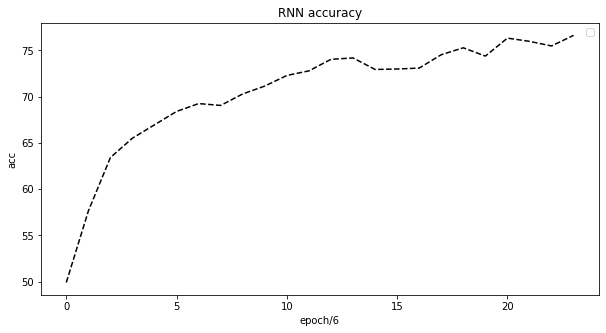

In [10]:
plt.figure(figsize=(10, 5))
plt.title('RNN accuracy')
plt.xlabel('epoch/6')
plt.ylabel('acc')
plt.legend(loc='best')
plt.plot(acc_list, 'k--')